In [23]:
!pip install transformers

In [24]:
! pip install nilearn

In [25]:
from nilearn import datasets
from nilearn.datasets import load_mni152_template
from nilearn.image import resample_to_img
from nilearn import masking
from nilearn import image as nimg
from nilearn import plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import MultiTaskLasso
import torch
from transformers import TimeSeriesTransformerConfig, TimeSeriesTransformerModel, TimeSeriesTransformerForPrediction
from nilearn.decomposition import CanICA
from nilearn.plotting import plot_prob_atlas
from sklearn.model_selection import train_test_split

In [26]:
n_subjects = 5
adhd_dataset = datasets.fetch_adhd(n_subjects=n_subjects)
adhd_raw_data = nimg.get_data(nimg.load_img(adhd_dataset.func[0]))
print(adhd_raw_data.shape)

(61, 73, 61, 176)


In [27]:
#ica = CanICA()
#ica.fit(adhd_dataset.func)

In [28]:
#plot_prob_atlas(ica.components_img_, title='Independent Components')

In [29]:
template = load_mni152_template(resolution=4)
mask_img = masking.compute_epi_mask(template)

In [30]:
ica = CanICA(mask=mask_img)
ica.fit(adhd_dataset.func)

/usr/local/lib/python3.10/dist-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and computation time.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/nilearn/maskers/nifti_masker.py:110: UserWarning: imgs are being resampled to the mask_img resolution. This process is memory intensive. You might want to provide a target_affine that is equal to the affine of the imgs or resample the mask beforehand to save memory and 

CanICA(mask=<nibabel.nifti1.Nifti1Image object at 0x7d41761c2350>)

/usr/local/lib/python3.10/dist-packages/nilearn/plotting/displays/_axes.py:74: UserWarning: linewidths is ignored by contourf
  im = getattr(ax, type)(
/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1454: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/usr/local/lib/python3.10/dist-packages/matplotlib/contour.py:1455: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())


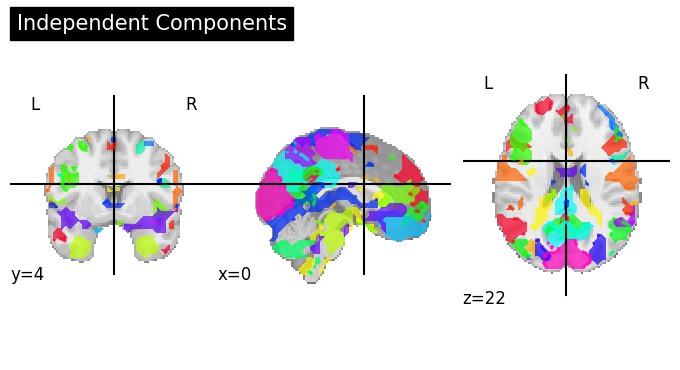

In [31]:
plot_prob_atlas(ica.components_img_, title='Independent Components')

In [32]:
icn = []
for i in range(n_subjects):
  icn.append(ica.transform(adhd_dataset.func)[i])

In [33]:
past_values = []
future_values = []
past_time_features = []
future_time_features = []
static_categorical_features = []
for i in range(n_subjects):
  start = 0
  while start + 24 < icn[i].shape[0]:
    past_values.append(icn[i][start : start+20])
    future_values.append(icn[i][start+20 : start+24])
    past_time_features.append(range(start, start+20))
    future_time_features.append(range(start+20, start+24))
    static_categorical_features.append(i)
    start += 4
past_values = torch.Tensor(past_values)
future_values = torch.Tensor(future_values)
past_time_features = torch.Tensor(past_time_features)
future_time_features = torch.Tensor(future_time_features)
past_time_features = past_time_features.reshape((past_time_features.shape[0], past_time_features.shape[1], 1))
future_time_features = future_time_features.reshape((future_time_features.shape[0], future_time_features.shape[1], 1))
past_observed_mask = torch.ones(past_values.shape)
static_categorical_features = torch.Tensor(static_categorical_features).int()

In [34]:
past_time_features.shape, future_time_features.shape

(torch.Size([166, 20, 1]), torch.Size([166, 4, 1]))

In [35]:
past_values.shape, future_values.shape # [batch_size x time x features]

(torch.Size([166, 20, 20]), torch.Size([166, 4, 20]))

In [108]:
n = past_values.shape[0]
test_size = 0.2
test_idx = np.random.choice(range(n), size=int(test_size * n), replace=False)
train_idx = np.setdiff1d(range(n), test_idx)
train_past_values = past_values[train_idx]
test_past_values = past_values[test_idx]
train_future_values = future_values[train_idx]
test_future_values = future_values[test_idx]
train_past_time_features = past_time_features[train_idx]
test_past_time_features = past_time_features[test_idx]
train_future_time_features = future_time_features[train_idx]
test_future_time_features = future_time_features[test_idx]
train_past_observed_mask = past_observed_mask[train_idx]
test_past_observed_mask = past_observed_mask[test_idx]
train_static_categorical_features = static_categorical_features[train_idx]
test_static_categorical_features = static_categorical_features[test_idx]

In [109]:
batch_size = 64
train_dataset = []
for i in range(train_past_values.shape[0]):
    train_dataset.append({
        "past_values": train_past_values[i],
        "future_values": train_future_values[i],
        "past_time_features": train_past_time_features[i],
        "future_time_features": train_future_time_features[i],
        "past_observed_mask": train_past_observed_mask[i],
        "static_categorical_features": train_static_categorical_features[i]
    })

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = []
for i in range(test_past_values.shape[0]):
    test_dataset.append({
        "past_values": test_past_values[i],
        "future_values": test_future_values[i],
        "past_time_features": test_past_time_features[i],
        "future_time_features": test_future_time_features[i],
        "past_observed_mask": test_past_observed_mask[i],
        "static_categorical_features": test_static_categorical_features[i]
    })

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [110]:
lags_sequence = [1, 2, 3, 4, 5, 6, 7]
configuration = TimeSeriesTransformerConfig(prediction_length=4, context_length=20 - len(lags_sequence), input_size=20,
                                            num_time_features=1, lags_sequence=lags_sequence, num_parallel_samples=1,
                                            num_static_categorical_features=1, cardinality=[n_subjects], embedding_dimension=[1])
model = TimeSeriesTransformerForPrediction(configuration)
optimizer = torch.optim.AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

In [111]:
n_epochs = 2000
print_every = 100
train_losses = []
test_losses = []
for epoch in range(n_epochs):
    for idx, batch in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()

        loss = model(
            past_values=batch["past_values"],
            future_values=batch["future_values"],
            past_time_features=batch["past_time_features"],
            future_time_features=batch["future_time_features"],
            past_observed_mask=batch["past_observed_mask"],
            static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
        ).loss
        loss.backward()
        train_losses.append(loss.item())

        optimizer.step()

        if epoch % print_every == 0 and idx == 0:
            print("Epoch: ", epoch, ", Train loss: ", loss.item(), end="", sep="")

    for idx, batch in enumerate(test_dataloader):
        model.eval()
        loss = model(
            past_values=batch["past_values"],
            future_values=batch["future_values"],
            past_time_features=batch["past_time_features"],
            future_time_features=batch["future_time_features"],
            past_observed_mask=batch["past_observed_mask"],
            static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
        ).loss
        test_losses.append(loss.item())
        if epoch % print_every == 0 and idx == 0:
            print(", Test loss:", loss.item())


Epoch: 0, Train loss: 285.5389099121094, Test loss: 281.75048828125
Epoch: 100, Train loss: 222.84957885742188, Test loss: 222.00559997558594
Epoch: 200, Train loss: 209.48028564453125, Test loss: 208.36827087402344
Epoch: 300, Train loss: 202.36376953125, Test loss: 202.4145050048828
Epoch: 400, Train loss: 198.3682403564453, Test loss: 197.07093811035156
Epoch: 500, Train loss: 209.1956787109375, Test loss: 198.2464141845703
Epoch: 600, Train loss: 199.32589721679688, Test loss: 192.83612060546875
Epoch: 700, Train loss: 192.28317260742188, Test loss: 191.2509765625
Epoch: 800, Train loss: 190.0796356201172, Test loss: 189.39944458007812
Epoch: 900, Train loss: 194.0974884033203, Test loss: 192.76185607910156
Epoch: 1000, Train loss: 191.29766845703125, Test loss: 188.12887573242188
Epoch: 1100, Train loss: 187.24267578125, Test loss: 190.16664123535156
Epoch: 1200, Train loss: 193.0291748046875, Test loss: 186.35105895996094
Epoch: 1300, Train loss: 189.173828125, Test loss: 188.980

In [112]:
len(train_losses)

6000

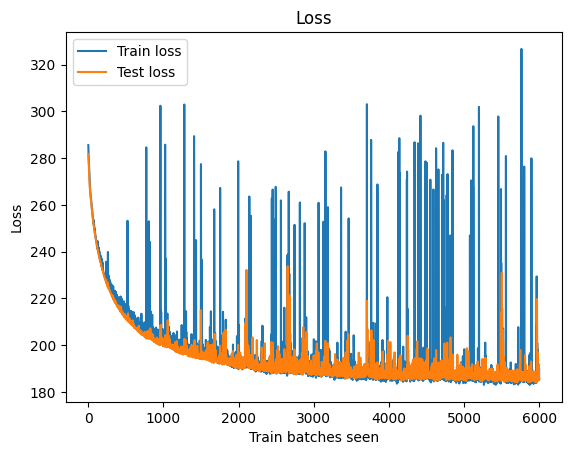

In [113]:
plt.plot(range(len(train_losses)), train_losses, label='Train loss')
ratio = int(len(train_losses) / len(test_losses))
plt.plot(np.linspace(0, len(train_losses), len(test_losses)), test_losses, label='Test loss')

# Adding labels and title
plt.xlabel('Train batches seen')
plt.ylabel('Loss')
plt.title('Loss')

# Adding legend
plt.legend()

# Show plot
plt.show()

In [117]:
test_static_categorical_features[0].reshape((1, 1)).shape

torch.Size([1, 1])

In [118]:
test_past_observed_mask[i].shape

torch.Size([20, 20])

In [119]:
test_future_time_features[i].shape

torch.Size([4, 1])

In [122]:
for idx, batch in enumerate(test_dataloader):
  model.eval()
  input = batch
  gen = model.generate(
      past_values=batch["past_values"],
      past_time_features=batch["past_time_features"],
      future_time_features=batch["future_time_features"],
      past_observed_mask=batch["past_observed_mask"],
      static_categorical_features=batch["static_categorical_features"].reshape((batch["static_categorical_features"].shape[0], 1))
  )["sequences"]
  print(gen.shape) # [batch_size, num_samples, prediction_length, input_size]

torch.Size([33, 1, 4, 20])


In [127]:
gen = gen.reshape((33, 4, 20))

In [130]:
result = torch.cat((input["past_values"], gen), dim=1)
result.shape

torch.Size([33, 24, 20])

In [131]:
result = result.reshape((33, 20, 24))

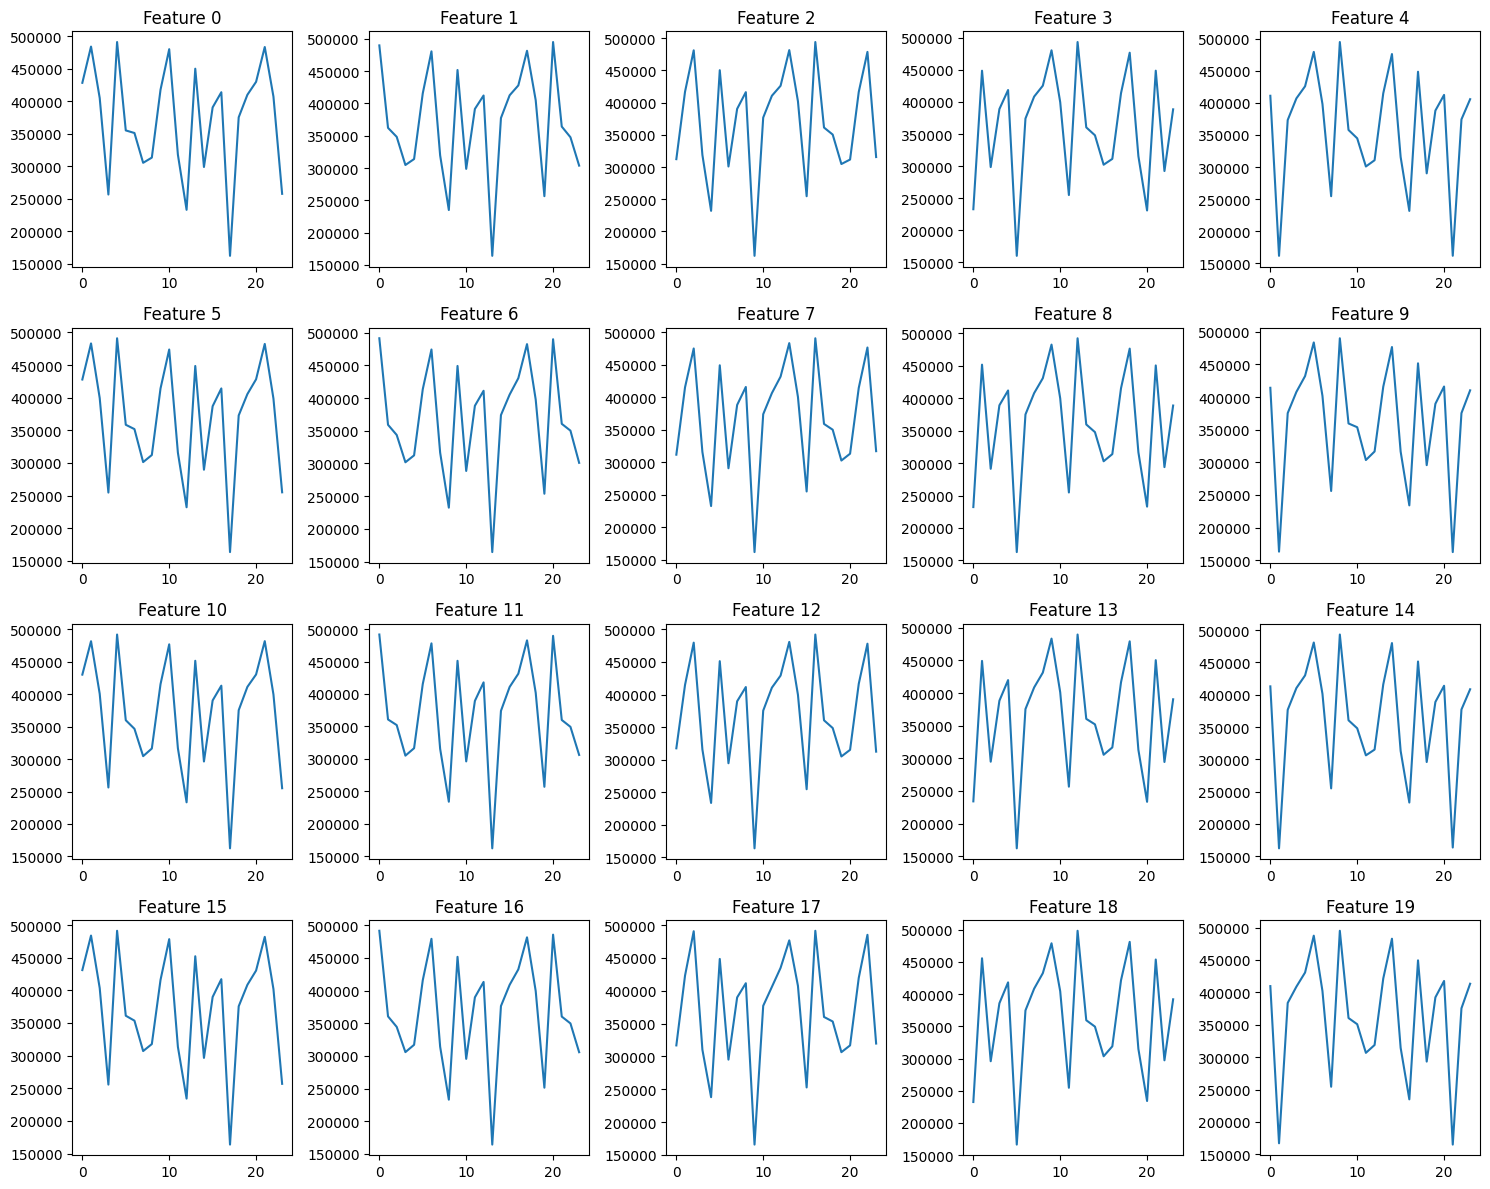

In [134]:
fig, axs = plt.subplots(4, 5, figsize=(15, 12))
axs = axs.flatten()
for i in range(result.shape[1]):
    ax = axs[i]
    ax.plot(result[0][i])
    ax.set_title(f'Feature {i}')
plt.tight_layout()
plt.show()